In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

In [2]:
data_path = '/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data'

## Loading Mask

In [4]:
mask = hp.read_map(data_path+'/Planck/mask/mask.fits')

0.0 180.0 -180.0 180.0


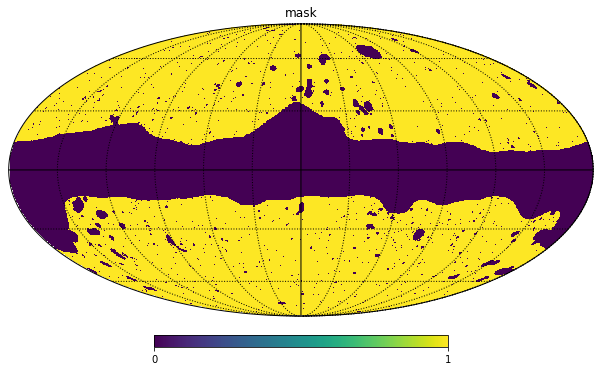

In [3]:
hp.mollview(mask, title='mask')
hp.graticule()

## Loading Map and Masking

In [4]:
dat = hp.read_alm(data_path+'/Planck/MV/dat_klm.fits')

In [4]:
image = hp.sphtfunc.alm2map(dat, nside=2048, pol=False, fwhm=(1*u.arcmin).to(u.rad).value)
image_masked = hp.ma(image)
image_masked.mask = np.logical_not(mask)

0.0 180.0 -180.0 180.0


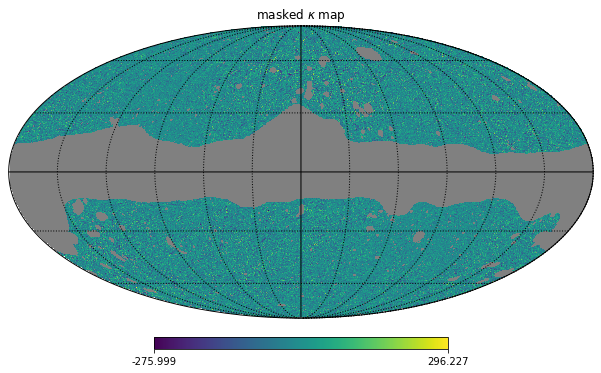

In [5]:
hp.mollview(image_masked.filled(), title='masked $\kappa$ map')
hp.graticule()

## Query from a specific position

In [45]:
pos = hp.ang2vec(theta=np.pi/6, phi=0)

In [60]:
idx = hp.query_disc(nside=2048, vec=pos, radius=np.radians(1))

In [61]:
new_image = image_masked.copy()
new_image[idx] = new_image.max()

In [68]:
choose = np.zeros(image_masked.shape, bool)
choose[idx] = True
values = image_masked[idx]
values = values[np.logical_not(values.mask)].data

In [69]:
values.shape

(3750,)

0.0 180.0 -180.0 180.0


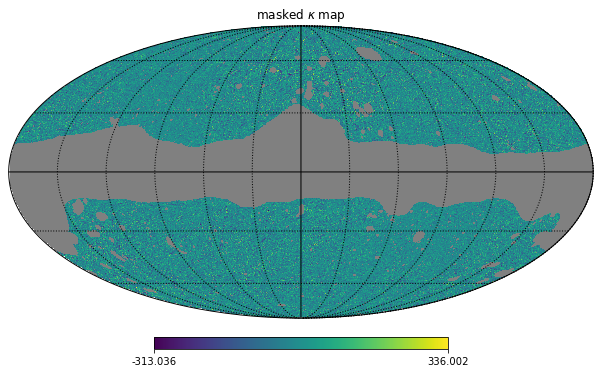

In [22]:
dat = hp.read_alm('../data/Planck/MV/dat_klm.fits')
image = hp.sphtfunc.alm2map(dat, nside=2048, pol=False)
image_masked = hp.ma(image)
image_masked.mask = np.logical_not(mask)
hp.mollview(image_masked.filled(), title='masked $\kappa$ map')
hp.graticule()

(array([1.1000000e+01, 2.9700000e+02, 1.5864000e+04, 6.5793600e+05,
        1.0519776e+07, 1.9493553e+07, 2.9653350e+06, 9.8951000e+04,
        2.1230000e+03, 4.8000000e+01]),
 array([-509.70524621, -412.3966519 , -315.08805758, -217.77946326,
        -120.47086894,  -23.16227462,   74.1463197 ,  171.45491402,
         268.76350834,  366.07210266,  463.38069698]),
 <BarContainer object of 10 artists>)

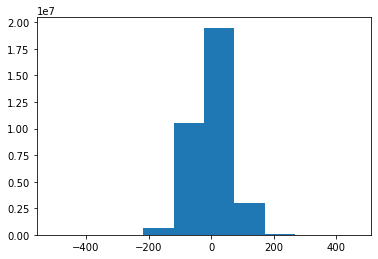

In [23]:
plt.hist(image[mask.astype(bool)])

## Switch to low resolution

In [62]:
mask_2 = hp.ud_grade(mask, 1024)
mask_2[mask_2>0.5] = 1
mask_2[mask_2<=0.5] = 0

In [63]:
image_2 = hp.sphtfunc.alm2map(dat, nside=1024, pol=False, fwhm=(1*u.arcmin).to(u.rad).value)
image_masked_2 = hp.ma(image_2)
image_masked_2.mask = np.logical_not(mask_2)

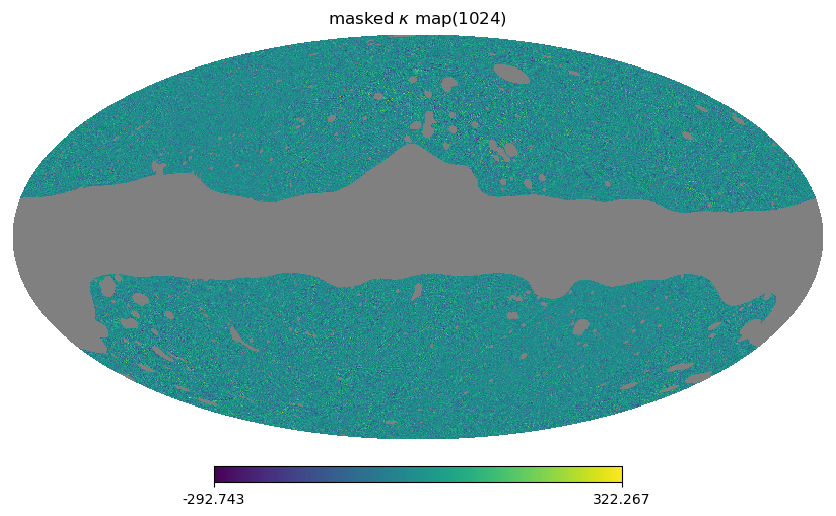

In [9]:
hp.mollview(image_masked_2.filled(), title='masked $\\kappa$ map(1024)')

## BallTree

In [64]:
theta, phi = hp.pix2ang(nside=1024, ipix=np.arange(hp.nside2npix(1024)))
index = np.logical_not(image_masked_2.mask)

b_k = np.pi/2 - theta[index]
l_k = phi[index]
kappa = image_masked_2.data[index]

In [65]:
from sklearn.neighbors import BallTree
tree = BallTree(data=np.vstack((b_k, l_k)).T, leaf_size=5, metric='haversine')          # latitude + logtitude

### Test
BallTree consist with hp.query

In [68]:
Nrand = 10000
theta = np.arccos(np.random.uniform(-1, 1, Nrand))
phi = np.random.uniform(0, 2*np.pi, Nrand)
radius = np.random.uniform(1e-3, 1, Nrand)

In [70]:
import tqdm

In [71]:
result = []
for i in tqdm.trange(Nrand):
    inside = image_masked_2[hp.query_disc(1024, vec=hp.ang2vec(theta[i], phi[i]), radius=radius[i])]
    result.append(inside.data[~inside.mask].sum())

100%|██████████| 10000/10000 [01:22<00:00, 121.12it/s]


In [79]:
result_2 = []
for i in tqdm.trange(Nrand):
    inside = tree.query_radius([[np.pi/2-theta[i], phi[i]]], [radius[i]])
    result_2.append(kappa[inside[i]].sum())

100%|██████████| 10000/10000 [00:57<00:00, 173.73it/s]


In [80]:
np.isclose(result, result_2).all()

True

## $l$ cut

In [13]:
Nside = 2048
mask = hp.read_map('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/Planck/mask/mask.fits')
dat, lmax = hp.read_alm('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/Planck/MV/dat_klm.fits', return_mmax=True)

l, m = hp.Alm.getlm(lmax)

l_cut = 2048

dat[np.logical_or(l<8, l>l_cut)] = 0

image = hp.sphtfunc.alm2map(dat, nside=Nside)
mask = hp.ud_grade(mask, Nside)
image_masked = hp.ma(image)
image_masked.mask = mask<=0.5


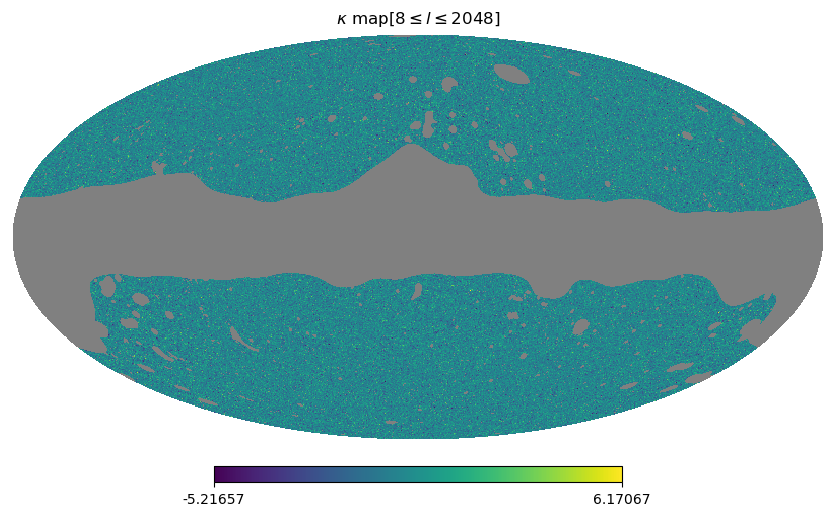

In [5]:
hp.mollview(image_masked.filled(), title='$\\kappa$ map[$8\\leq l\\leq 2048$]')
plt.savefig('./fig/kappa_map')

In [39]:
theta, phi = hp.pix2ang(Nside, np.arange(len(image)))
l_k = phi[np.logical_not(image_masked.mask)]
b_k = np.pi/2 - theta[np.logical_not(image_masked.mask)]
kappa = image[np.logical_not(image_masked.mask)]
# np.save(f'../catalogue/CMB_lcut_{l_cut}', [l_k, b_k, kappa])

## shuffle $\kappa$

In [18]:
np.random.shuffle(kappa)
np.save(f'../catalogue/CMB_lcut_{l_cut}_shuffle_3', [l_k, b_k, kappa])

## shuffle $\kappa$ within the random point footprint

In [19]:
import astropy.coordinates as coo
from astropy.cosmology import Planck18 as cosmos
h = cosmos.H0.value / 100

In [20]:
z = 1.5
distance = cosmos.comoving_distance(z).to('Mpc').value*h
max_angular_scale = 100 / distance * (180/np.pi)*60
print(f'angular scale ~ {max_angular_scale} arcmin')

angular scale ~ 113.4842514396305 arcmin


In [40]:
Nside_sub = 25
print(f'healpix resolution ~ {hp.nside2resol(Nside_sub, True)} arcmin')
random_sample = np.load('../catalogue/random_quasar_lss_all.npy')
c = coo.SkyCoord(ra=random_sample['ra']*u.degree, dec=random_sample['dec']*u.degree)

l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pix_r = np.unique(hp.ang2pix(Nside_sub, theta=np.pi/2-b, phi=l))
flag = np.zeros(hp.nside2npix(Nside_sub), bool)
flag[pix_r] = True
pix_k = hp.ang2pix(Nside_sub, theta=np.pi/2 - b_k, phi=l_k)

toshuffle = flag[pix_k]

healpix resolution ~ 140.71752342804095 arcmin


In [47]:
shuffled_kappa = kappa[toshuffle]
np.random.shuffle(shuffled_kappa)
kappa[toshuffle] = shuffled_kappa

In [48]:
np.save(f'../catalogue/CMB_lcut_{l_cut}_partly_shuffle_7', [l_k, b_k, kappa])

## smoothing

In [49]:
mask = hp.read_map(data_path+'/Planck/mask/mask.fits')
dat, lmax = hp.read_alm(data_path+'/Planck/MV/dat_klm.fits', return_mmax=True)

In [55]:
Nside = 2048
smoothing_scale = 8

In [56]:
image = hp.sphtfunc.alm2map(dat, nside=Nside, fwhm=(smoothing_scale*u.arcmin).to(u.rad).value)
mask = hp.ud_grade(mask, Nside)
image_masked = hp.ma(image)
image_masked.mask = mask<=0.5

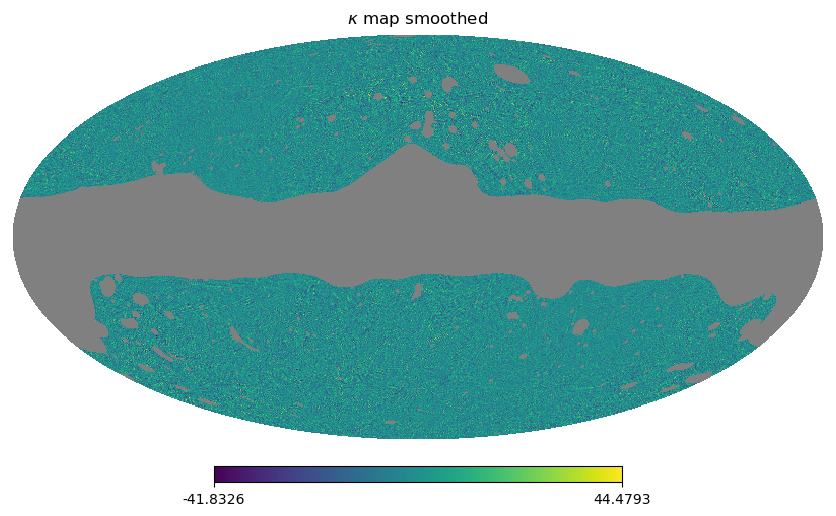

In [12]:
hp.mollview(image_masked.filled(), title='$\\kappa$ map smoothed')

In [57]:
theta, phi = hp.pix2ang(Nside, np.arange(len(image)))
l_k = phi[np.logical_not(image_masked.mask)]
b_k = np.pi/2 - theta[np.logical_not(image_masked.mask)]
kappa = image[np.logical_not(image_masked.mask)]
np.save(f'../catalogue/CMB_smoothed_{smoothing_scale}', [l_k, b_k, kappa])

## Some calculation about kappa map

In [2]:
k_lm, lmax = hp.read_alm('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/Planck/MV/dat_klm.fits', return_mmax=True)
print(lmax)
l, m = hp.Alm.getlm(lmax)
phi_lm = k_lm/(l*(l+1)/2+1e-20)

4096


In [11]:
Nside = 1024
mask = hp.read_map('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/Planck/mask/mask.fits')

image = hp.sphtfunc.alm2map(k_lm_new, nside=Nside, pol=False)
mask = hp.ud_grade(mask, Nside)
image_masked = hp.ma(image)
image_masked.mask = mask<=0.5

theta, phi = hp.pix2ang(Nside, np.arange(len(image)))
l_k = phi[np.logical_not(image_masked.mask)]
b_k = np.pi/2 - theta[np.logical_not(image_masked.mask)]
kappa = image[np.logical_not(image_masked.mask)]
np.save('../catalogue/CMB_test', [l_k, b_k, kappa])

[]

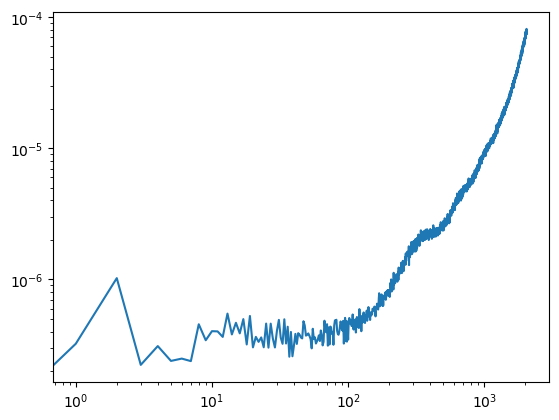

In [48]:
cl = hp.alm2cl(klm)
L = np.arange(len(cl))
plt.plot(cl/np.pi)
plt.loglog()

In [152]:
dat = hp.read_alm('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/Planck/MV/dat_klm.fits')
l, m = hp.Alm.getlm(4096)
choose = l <= 2048
dat_lcut = dat[choose]

<Axes: ylabel='Count'>

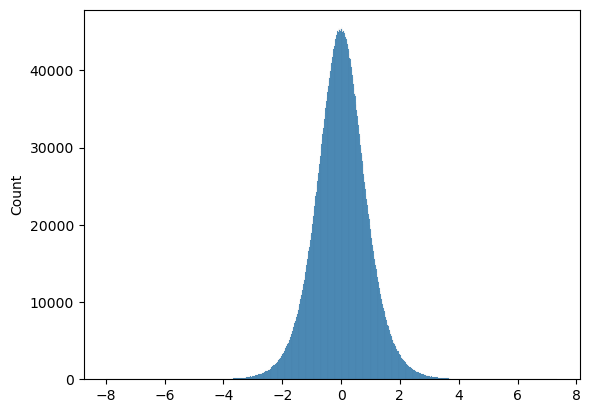

In [149]:
image = hp.sphtfunc.alm2map(dat_lcut, nside=Nside, pol=False)
mask = hp.ud_grade(mask, Nside)
image_masked = hp.ma(image)
image_masked.mask = mask<=0.5
kappa = image[np.logical_not(image_masked.mask)]
# hp.mollview(image_masked.filled())
sns.histplot(kappa)

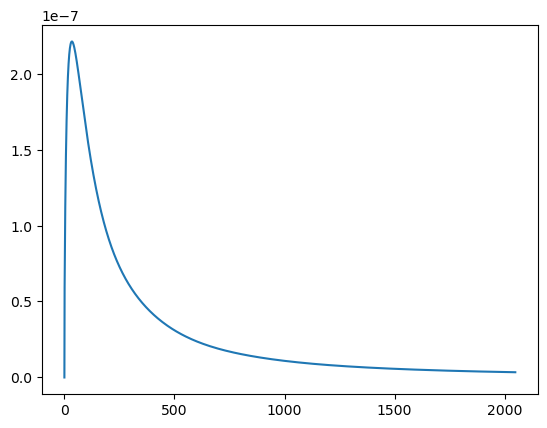

In [44]:
nlkk = np.loadtxt('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/Planck/PP/nlkk.dat')
plt.plot(nlkk[:,2]-nlkk[:,1])

In [26]:
mf_lm = hp.read_alm('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/data/Planck/TT/mf_klm.fits')

[]

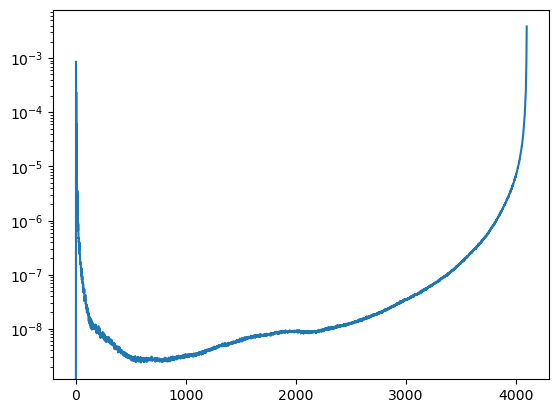

In [28]:
plt.plot(hp.alm2cl(mf_lm))
plt.semilogy()

In [49]:
l, m = hp.Alm.getlm(4096)

In [3]:
Nside = 2048
mask = hp.read_map('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/Planck/mask/mask.fits')
dat, lmax = hp.read_alm('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/Planck/MV/dat_klm.fits', return_mmax=True)

l, m = hp.Alm.getlm(lmax)
dat[np.logical_or(l<8, l>2048)] = 0

In [9]:
map, dtheta, dphi = hp.alm2map_der1(dat, Nside)

In [10]:
gradient = (dtheta**2+dphi**2)

In [16]:
gradient.max()

165281699.0043594

In [17]:
np.percentile(gradient, 50)

520165.6052234784

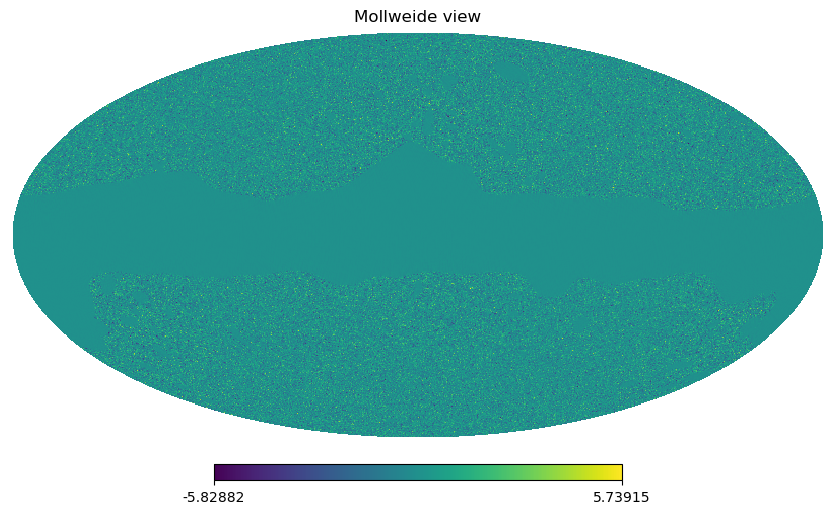

In [12]:
hp.mollview(map)